In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.896825 -0.665951 -0.702161 -1.834831 -0.525319 -0.704853 -0.440582   
  1  -0.298541 -0.170268 -0.411734 -0.401027 -0.023756  0.148258 -0.055674   
  2   0.217838 -0.072796  0.087032  0.277755 -0.471501  0.040092  0.023731   
  3  -0.032167 -0.662315 -1.901733 -0.876004 -0.364425  0.725040  0.156344   
  4   0.041107 -0.316028 -1.013353 -0.848167 -0.394163  0.752600 -0.103302   
  5  -0.409926  0.729613 -0.021650  0.111605 -0.082391 -0.295723  0.679511   
  6  -0.668427 -0.001567 -0.106434 -0.278979 -0.387251 -1.361359 -0.630178   
  7  -0.408526  0.007067  0.034330  0.433639  0.516818  0.286810 -0.315002   
  8  -0.356602 -0.164695 -0.163067 -0.935513  0.389625 -0.090860  0.679421   
  9  -0.879534  0.072118  0.183964  0.105244 -0.767228  0.188450  0.431564   
  10 -0.508814  0.326570 -0.369812 -0.554118  0.573169 -0.600930  0.155069   
  11 -0.705093 -0.826379 -1.151422 -0.197071 -0.344662  0.766945 -0.956842   
  12 -0.357286 -0.118379 -0.740843  0.472896 -0.330645  0.408685 -0.227069   
  13  0.525966  0.359097  0.338448 -0.240087 -0.556811 -0.573276 -0.216728   
  14  0.094767 -0.457190 -0.566072 -0.035719 -0.657844  0.298463 -0.124108   
  15 -0.080881 -0.709068 -0.293279 -0.866198 -1.138530 -0.146961 -1.066816   
  16  1.242607  0.058817 -0.246071  0.497447  0.085220 -0.494510 -0.241442   
  17  0.939187  0.884700 -0.517836  0.407543 -0.274558 -0.621180 -0.975673   
  18 -0.301464  0.223977 -0.704143 -0.333140  0.347541  0.684720  0.138604   
  19  0.862721  0.022099 -0.892742 -0.438080 -0.436667 -0.084690  0.199464   
  20  0.410337 -0.189782 -0.393356 -0.632999 -0.077000  0.356548 -0.432072   
  21  1.005404  0.674242  0.681905 -0.166128  0.284153 -0.297361  0.259932   
  22  0.418407  0.295841 -0.231955 -0.255100  0.866681  0.409167 -0.140771   
  23  0.358782 -1.081881 -1.193014 -0.889092  0.150400  0.234626  0.060773   
  24 -0.046970 -0.901332 -1.050089 -0.860162 -0.993432  0.109073 -0.046689   
1 0   0.103911 -0.871221 -0.316652 -0.135360  0.323885  1.339429 -0.175629   
  1  -0.029402 -0.429445  1.173719  0.654723 -0.773572  0.353958  0.194755   
  2   0.964290  0.295681  1.630793  0.476116  0.157856  0.094226 -0.186059   
  3  -0.192785 -0.291051  0.298351  0.078456 -0.520414  0.058991  0.109469   
  4   0.955682  0.084529  0.749373  1.133088 -0.753523  0.573192 -0.276402   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.359274 -0.219456 -1.498307  ... -0.030461  0.942645  0.159644   
  1  -0.589810  0.330179 -1.180166  ...  0.768438  0.979837 -0.430808   
  2   0.623385 -0.209892 -0.489053  ...  0.534252  0.257179  0.814855   
  3  -0.380671 -0.406376 -0.165675  ... -0.031578  0.667279 -0.122758   
  4  -0.271387  0.522078  0.142484  ... -0.844634 -0.204328 -0.273037   
  5  -0.331842 -0.323193 -0.601060  ...  0.080155  0.891797  0.598516   
  6   0.301677  1.141710  0.028816  ...  0.787607  0.380198  0.297412   
  7   0.132209  0.484187  0.242882  ... -0.795651 -0.549457  0.322778   
  8  -0.505847 -0.723393 -0.442589  ...  0.029335 -0.394703 -0.381888   
  9   0.090430  0.761941  0.434912  ...  0.202816  0.178718 -0.688796   
  10 -0.440159 -0.221273  0.015856  ...  0.074687 -0.222981 -0.706643   
  11 -0.295259  1.200700 -0.243366  ... -0.406611 -0.036442 -0.856698   
  12 -0.442106  0.746201 -0.565252  ... -0.290489 -0.463620  0.210035   
  13  0.461087  1.629727  0.766318  ... -0.619309 -0.360255  0.176618   
  14 -0.622505 -0.144158 -1.002599  ... -0.205112 -0.496649 -0.537618   
  15 -0.221685 -0.458308 -1.160828  ... -0.165666 -0.649683 -0.241013   
  16 -0.188923  0.114989  0.308821  ...  0.211244 -0.174208  0.146403   
  17 -0.372223 -0.857568  0.026066  ...  0.606550  0.283791 -0.147108   
  18  0.773388  0.213825 -1.935350  ...  0.605827 -0.293250  0.522403   
  19 -0.089526  0.357435 -0.354553  ...  0.089508 -0.179309  0.591093   
  20 -0.338332 -0.943384 -1.067155  ...  0.835615  0.329778 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|    2.5 %    97.5 %
D  0.974432  0.038777  25.128973  2.399575e-139  0.89843  1.050434


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



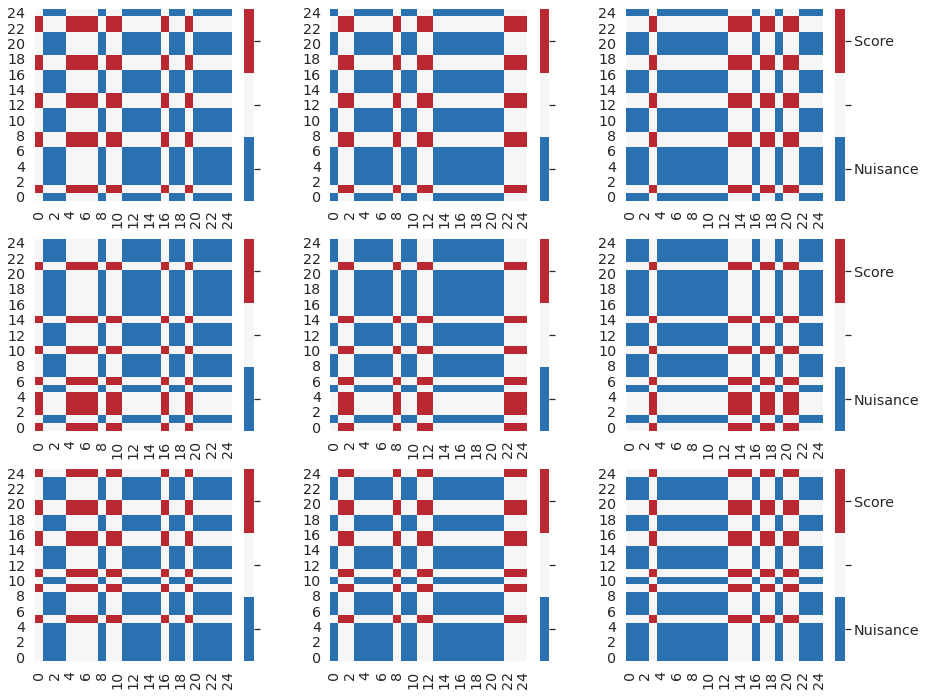

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



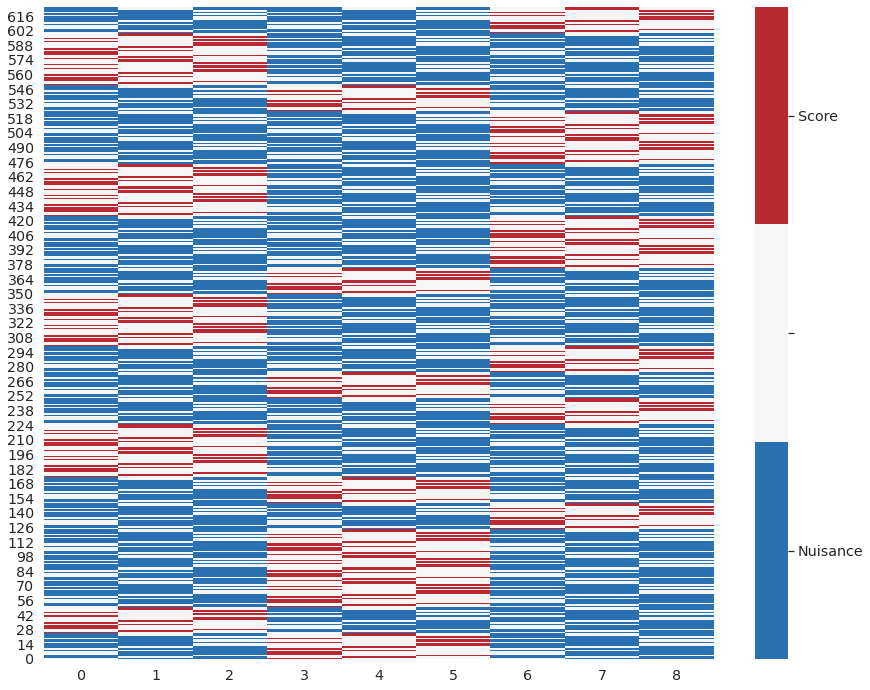

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])